<a href="https://colab.research.google.com/github/Matvej911/Matvejs_Aleksejevs_DLBAIPNLP01/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Instal the Hugging Face Transformers library, which provides pre-trained models for natural language processing tasks.

In [13]:
!pip install transformers

In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

Load and preprocess the spam and ham datasets. Combine two datasets, shuffle, and reset the index for consistency.

In [15]:
df1 = pd.read_csv('dataset_small_1.csv')
df1 = df1[['label_num', 'text']]
df1.rename(columns={'text': 'Message', 'label_num': 'Category'}, inplace=True)

df2 = pd.read_csv('dataset_small_2.csv')
df2['Category'] = df2['Category'].map({'ham': 0, 'spam': 1})

combined_df = pd.concat([df1, df2], ignore_index=True)
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)


##If you want to use large dataset use instructions below

####Upload Your Kaggle API Key
Kaggle requires an API key to access datasets. If you don't have your kaggle.json file yet, here's how to get it:

####Go to the Kaggle website.
Click on your profile picture in the top right and select "Account".
Scroll down to the "API" section and click "Create New API Token". This will download a kaggle.json file containing your API key.
#####Next, upload this kaggle.json file to Colab:

In [16]:
#!pip install kaggle

In [17]:
"""
from google.colab import files
files.upload()  # Upload the kaggle.json file
"""

'\nfrom google.colab import files\nfiles.upload()  # Upload the kaggle.json file\n'

####After uploading, move the kaggle.json file to the .kaggle directory:

In [18]:
"""
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
"""

'\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n'

####Step 2: Download the Dataset
Now that the Kaggle CLI is set up, you can download the dataset using the kaggle datasets download command.

In [19]:
"""
!kaggle datasets download -d meruvulikith/190k-spam-ham-email-dataset-for-classification
"""

'\n!kaggle datasets download -d meruvulikith/190k-spam-ham-email-dataset-for-classification\n'

####Step 3: Unzip the Dataset
The dataset will be downloaded as a zip file. Unzip it using the following command:

In [20]:
"""
!unzip 190k-spam-ham-email-dataset-for-classification.zip
"""

'\n!unzip 190k-spam-ham-email-dataset-for-classification.zip\n'

In [21]:
"""
df3 = pd.read_csv('spam_Emails_data.csv')
df3.rename(columns={'text': 'Message', 'label': 'Category'}, inplace=True)
df3['Category'] = df3['Category'].map({'Ham': 0, 'Spam': 1})
df3 = df3.dropna(subset=['Message'])
df3.drop_duplicates(inplace=True)
df = df3
"""

"\ndf3 = pd.read_csv('spam_Emails_data.csv')\ndf3.rename(columns={'text': 'Message', 'label': 'Category'}, inplace=True)\ndf3['Category'] = df3['Category'].map({'Ham': 0, 'Spam': 1})\ndf3 = df3.dropna(subset=['Message'])\ndf3.drop_duplicates(inplace=True)\ndf = df3\n"

In [22]:
df.tail()

,Category,Message
10738,0,Geeeee ... I love you so much I can barely sta...
10739,0,Is that seriously how you spell his name?
10740,0,I have to take exam with march 3
10741,0,"Subject: re : meter 1459 , 6 / 00\r\nyep , you..."
10742,0,"No dice, art class 6 thru 9 :( thanks though. ..."


####Tokenization and Dataset Preparation
Initialize a BERT tokenizer and prepare the custom dataset class for tokenizing messages and creating PyTorch tensors.

In [23]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        message = str(self.data.Message[index])
        inputs = self.tokenizer.encode_plus(
            message,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=False
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.Category[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len


####Split the dataset into training and validation sets, and prepare DataLoaders for batching and shuffling the data.

In [24]:
max_len = 64
train_size = 0.8
train_dataset = EmailDataset(df, tokenizer, max_len)

train_data, val_data = random_split(train_dataset, [int(train_size * len(train_dataset)), len(train_dataset) - int(train_size * len(train_dataset))])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


####Initialize the BERT model for sequence classification and set up the AdamW optimizer with a learning rate.

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to('cuda')

optimizer = AdamW(model.parameters(), lr=1e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


####Define a training function to perform forward and backward passes, update weights, and calculate loss for each epoch.

In [26]:
train_losses = []

def train(epoch):
    model.train()
    epoch_losses = []
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to('cuda', dtype=torch.long)
        mask = data['mask'].to('cuda', dtype=torch.long)
        targets = data['targets'].to('cuda', dtype=torch.long)

        outputs = model(ids, attention_mask=mask, labels=targets)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}')

####Define a validation function to evaluate the model's performance on the validation set after each epoch.

In [27]:
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

def evaluate():
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):
            ids = data['ids'].to('cuda', dtype=torch.long)
            mask = data['mask'].to('cuda', dtype=torch.long)
            targets = data['targets'].to('cuda', dtype=torch.long)

            outputs = model(ids, attention_mask=mask)
            fin_outputs.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            fin_targets.extend(targets.cpu().numpy())

    return fin_outputs, fin_targets


####Train the model for a specified number of epochs and evaluate accuracy, precision, recall, and F1 score after each epoch.

In [28]:

num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    train(epoch)
    outputs, targets = evaluate()
    accuracy = accuracy_score(targets, outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, outputs, average='binary')

    # Store metrics
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    # Print metrics
    print(f'Epoch {epoch + 1}, Validation Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1, Training Loss: 0.1810
Epoch 1, Validation Accuracy: 0.9809
Precision: 0.9530
Recall: 0.9591
F1 Score: 0.9561


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 2, Training Loss: 0.0363
Epoch 2, Validation Accuracy: 0.9870
Precision: 0.9639
Recall: 0.9763
F1 Score: 0.9701


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 3, Training Loss: 0.0112
Epoch 3, Validation Accuracy: 0.9874
Precision: 0.9720
Recall: 0.9699
F1 Score: 0.9709


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 4, Training Loss: 0.0043
Epoch 4, Validation Accuracy: 0.9893
Precision: 0.9825
Recall: 0.9677
F1 Score: 0.9751


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 5, Training Loss: 0.0082
Epoch 5, Validation Accuracy: 0.9888
Precision: 0.9682
Recall: 0.9806
F1 Score: 0.9744


####Visualize the training loss, validation accuracy, precision, recall, and F1 score across epochs.

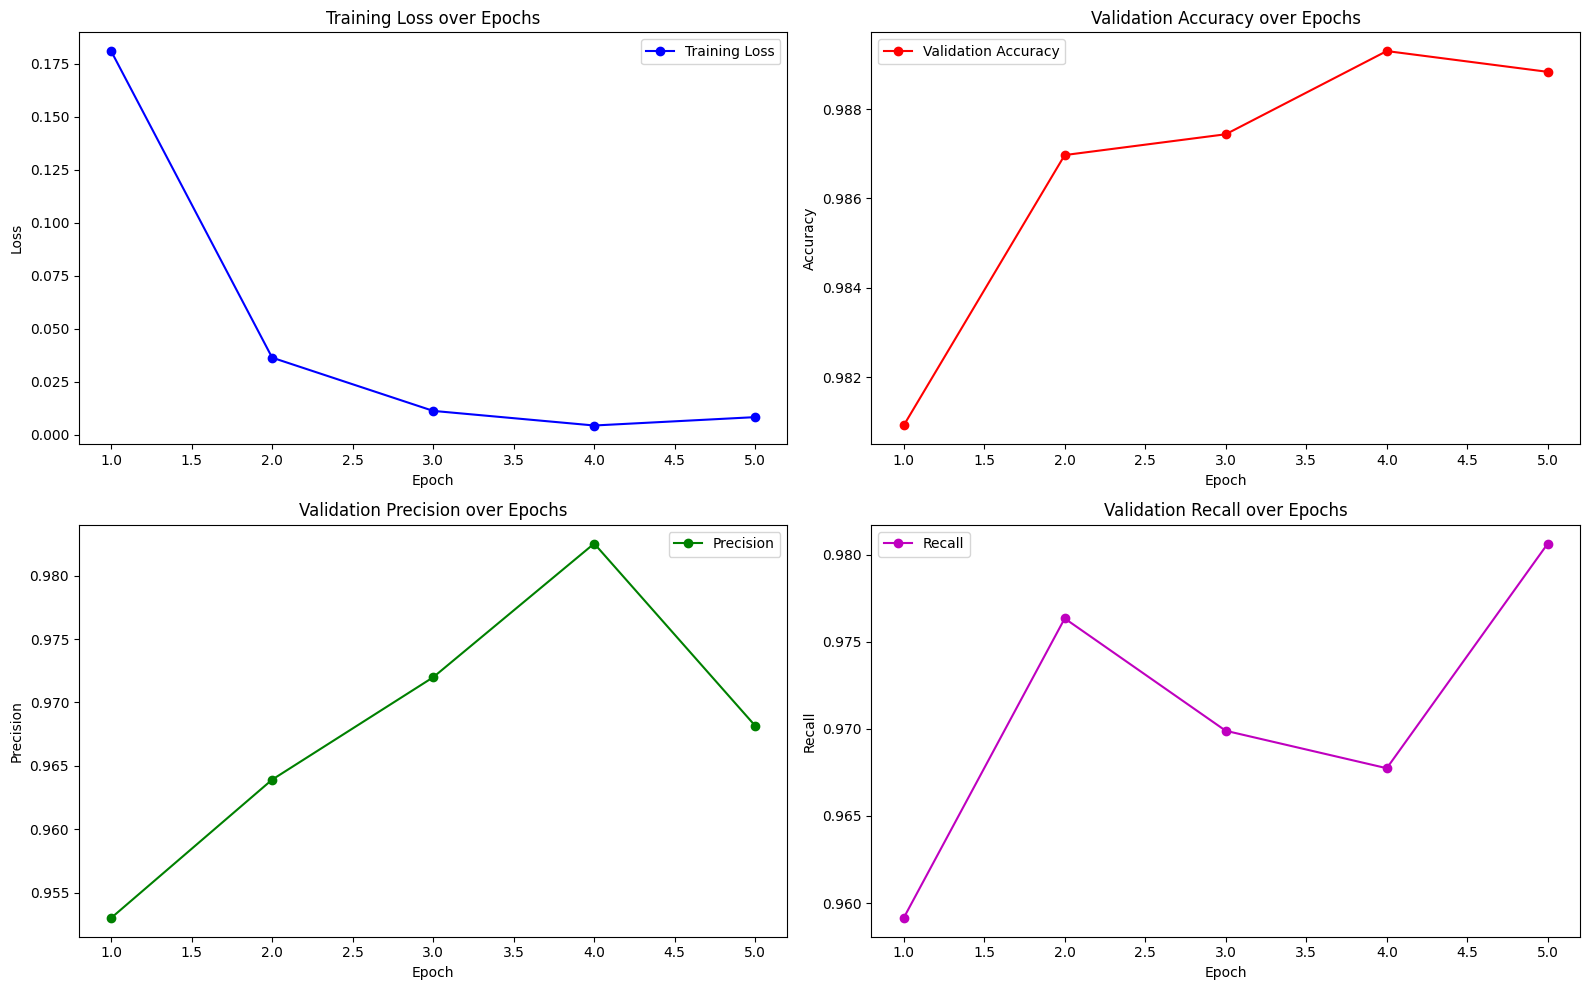

In [29]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', color='r', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, val_precisions, marker='o', color='g', label='Precision')
plt.title('Validation Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, val_recalls, marker='o', color='m', label='Recall')
plt.title('Validation Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


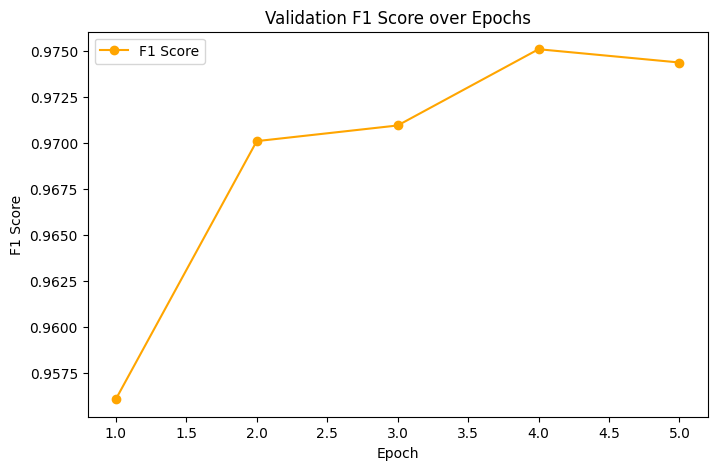

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_f1s, marker='o', color='orange', label='F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

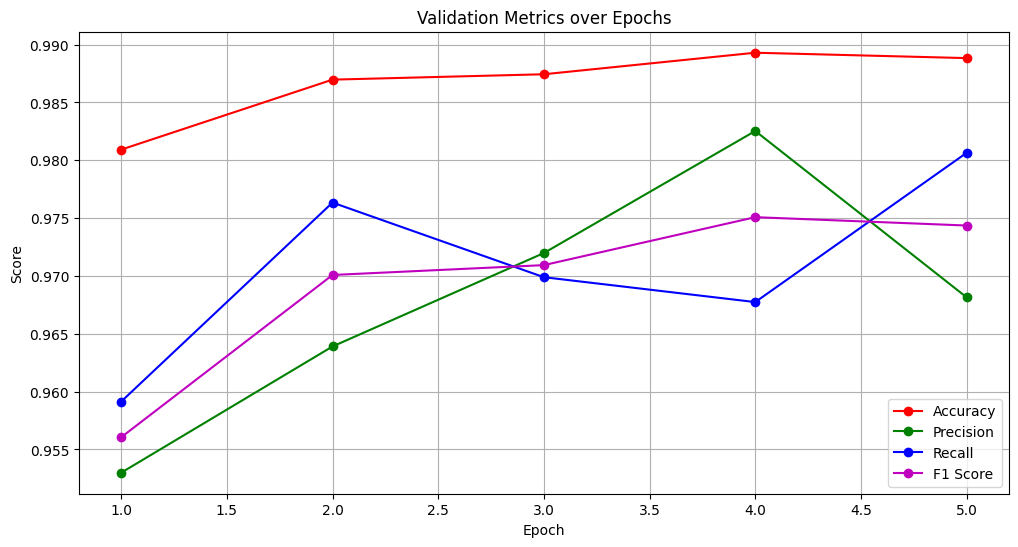

In [31]:
# Plotting Metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Plot Accuracy, Precision, Recall, and F1 Score
plt.plot(epochs, val_accuracies, marker='o', color='r', label='Accuracy')
plt.plot(epochs, val_precisions, marker='o', color='g', label='Precision')
plt.plot(epochs, val_recalls, marker='o', color='b', label='Recall')
plt.plot(epochs, val_f1s, marker='o', color='m', label='F1 Score')

plt.title('Validation Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.show()

In [32]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

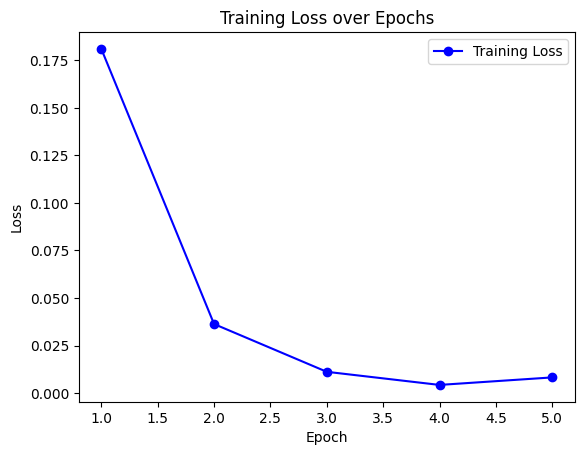

In [33]:
# Plot Loss

plt.plot(epochs, train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()